In [1]:
#imports
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
filename = os.path.join(os.getcwd(), "modeling_dataset.csv")
df = pd.read_csv(filename, header=0)

One Hot Encoding

In [3]:

df["TransceiverClass"] = df["TransceiverClass"].replace("A", 1)
df["TransceiverClass"] = df["TransceiverClass"].replace("B", 2)
df["PathChange"] = df["PathChange"].replace("stayed on course", 0)
df["PathChange"] = df["PathChange"].replace("veered off course", 1)

Change Status of System to numeric data type:

In [4]:
stofsys = df["Status of System"].unique()
count = 1
for status in stofsys:
    df["Status of System"] = df["Status of System"].replace(status, count)
    count = count + 1

Create training and test sets:

In [5]:
y = df['PathChange'] 
X = df.drop(columns = 'PathChange', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Create random forest model and find best hyperparameters:

In [7]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
criterion = ['gini', 'entropy', 'log_loss']
max_features = ['log2', 'sqrt', None]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid = {'n_estimators': n_estimators, 
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [8]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 218, 236, 254,
                                                         272, 290, 309, 327,
                                                         345, 363, 381, 400,
                                                         418, 436, 454, 472,
                                                         490, 509, 527, 545,
                                                         563, 581, 600, 618,
                                                         636, 654, 672, 690,
                                                         709, 727, ...]},
                   random_state=42, verbose=2)

In [9]:
rf_best = RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=600)
rf_best.fit(X_train, y_train)
rf_best_preds = rf_best.predict_proba(X_test)
rf_best_predictions = list(rf_best_preds[:, -1])
rf_best_predictbin = rf_best.predict(X_test)

Model performance:

Plotting ROC Curve...


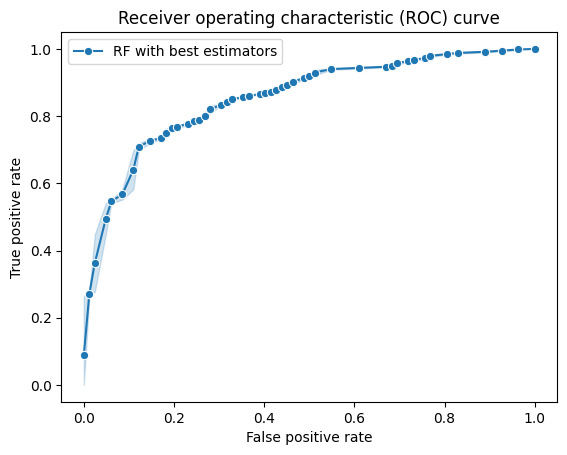

In [10]:
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, rf_best_predictions)
print('Plotting ROC Curve...')

fig = plt.figure()
ax = fig.add_subplot(111)


sns.lineplot(x=fpr_best, y=tpr_best, marker = 'o')

plt.title("Receiver operating characteristic (ROC) curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(['RF with best estimators'])
plt.show()


In [11]:
auc_best = auc(fpr_best, tpr_best)
print("AUC of the RF model with best estimators is {:.3f}".format(auc_best))

AUC of the RF model with best estimators is 0.856


In [12]:
accuracy_score(y_test, rf_best_predictbin)

0.8235294117647058

In [13]:
cf = confusion_matrix(y_test, rf_best_predictbin)
cf

array([[ 44,  38],
       [ 28, 264]])

In [14]:
precision = (cf[1][1]) / (cf[1][1] + cf[0][1])
precision

np.float64(0.8741721854304636)

In [15]:
recall = (cf[1][1]) / (cf[1][1] + cf[1][0])
recall

np.float64(0.9041095890410958)

In [17]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

np.float64(0.8888888888888888)